Uncomment if you are using Colab

In [ ]:
!pip install crowd-kit==1.0.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 32.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 56.7 MB/s eta 0:00:00


In [ ]:
import hashlib
from collections import Counter, defaultdict
from functools import lru_cache
from typing import Dict, Iterable, List, Set, Tuple

import IPython.display as ipd
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from crowdkit.aggregation import ROVER
from tabulate import tabulate
from tqdm.auto import tqdm

import re
import ipywidgets as widgets
from ipywidgets import interact
from sklearn.model_selection import train_test_split

plt.style.use("ggplot")

In [ ]:
SEED = 42
np.random.seed(SEED)

Uncomment if you are using Colab

In [ ]:
%%bash
mkdir -p ./data/audio
wget -q https://raw.githubusercontent.com/vadim0912/ML2023/master/lecture08/data/noisy_text_aggregation_test.jsonl -P data/
wget -q https://raw.githubusercontent.com/vadim0912/ML2023/master/lecture08/data/noisy_text_aggregation_train.jsonl -P data/
wget -q https://raw.githubusercontent.com/vadim0912/ML2023/master/lecture08/data/noisy_text_aggregation_text_only.csv -P data/

declare -a files=(
  "98962310d56cd7095d9893f5ed657f81.wav"
  "3c2875271fb918da312865549d444653.wav"
  "b4f6a8d9e2eba8085d25d4122b52d55a.wav"
  "ed0f6706f75681a7915fec15d336aca5.wav"
  "f3dba379c6280536aaa65a56c4358268.wav"
)

for file in "${files[@]}"; do
   wget -q https://raw.githubusercontent.com/vadim0912/ML2023/master/lecture08/data/audio/$file -P data/audio
done

# Problem Statement

Дано:
* три модели распознавания речи:
    * `qnet`: [QuartzNet](https://arxiv.org/abs/1910.10261)
    * `w2v`: [wav2vec XLS-R](https://arxiv.org/pdf/2111.09296.pdf)
    * `w2v-tts`: тот же [wav2vec XLS-R](https://arxiv.org/pdf/2111.09296.pdf), но в дообучении использовались синтезированные (Text-To-Speech) данные
   
   
 * модели имеют разную структуру (QuartzNet — сверточная, wav2vec — Трансформер) и обучались на разных данных => из их предсказаний можно построить композицию, которая сильнее любого кандидата в отдельности
 * В тренировочном наборе данных ~ 60 тысяч примеров с референсной транскрипцией `text` (ground truth; истинный текст) и гипотезой каждой из моделей
 * В тестовом наборе данных ~ 20 тысяч примеров с гипотезами от каждой из моделей, но без референсной транскрипции (ее нужно предсказать)
 * Также доступен миллион фраз из того же домена (запросы к ассистентам), но без предсказаний моделей

Задача: улучшить распознавание речи с помощью:
 * агрегации транскрипций
 * выбора лучшей транскрипции
 * исправления ошибок в транскрипциях

In [ ]:
train_df = pd.read_json("data/noisy_text_aggregation_train.jsonl", lines=True)

train_df.head()

,task,text,qnet,w2v,w2v_tts
0,ed0f6706f75681a7915fec15d336aca5,дамира николаевича,дамира николаевича,до мира николаевича,домера николаевича
1,3c2875271fb918da312865549d444653,антонине татариновой,онпанине то тариновый,антонине татариновый,антонини татариновый
2,f3dba379c6280536aaa65a56c4358268,жидкову,жит куву,жит куву,жидкову
3,98962310d56cd7095d9893f5ed657f81,главатских,лалаки,главатских,главацки
4,b4f6a8d9e2eba8085d25d4122b52d55a,мошкова,мошкова,машкова,мошкова


In [ ]:
MODEL_LIST = ["qnet", "w2v", "w2v_tts"]

In [ ]:
for i, row in train_df.head(5).iterrows():
    labels = [row[model] == row["text"] for model in MODEL_LIST]

    row_df = (
        train_df.drop({"task", "text"}, axis=1)
        .iloc[[i]]
        .style.set_properties(
            **{"background-color": "#aaffaa"},
            subset=[model for model, label in zip(MODEL_LIST, labels) if label],
        )
        .set_properties(
            **{"background-color": "#ffaaaa"},
            subset=[model for model, label in zip(MODEL_LIST, labels) if not label],
        )
        .set_properties(width="150px")
    )
    ipd.display(row_df)
    ipd.display(ipd.Audio(f"data/audio/{row['task']}.wav"))

,qnet,w2v,w2v_tts
0,дамира николаевича,до мира николаевича,домера николаевича


,qnet,w2v,w2v_tts
1,онпанине то тариновый,антонине татариновый,антонини татариновый


,qnet,w2v,w2v_tts
2,жит куву,жит куву,жидкову


,qnet,w2v,w2v_tts
3,лалаки,главатских,главацки


,qnet,w2v,w2v_tts
4,мошкова,машкова,мошкова


In [ ]:
test_df = pd.read_json("data/noisy_text_aggregation_test.jsonl", lines=True)

test_df.head()

,task,qnet,w2v,w2v_tts
0,73aff8bc8d99278c6ca6d1ac243557e3,дели,зили,зили
1,ba8443f3cc91e56667278db36dea02b7,вектор упавнович чунула к лещенуму,виктору павловичу новокрещеному,виктору павлновичу навокрещинову оо
2,af346fae1d5686a357e32710c5d4f13e,риме менниковой,римми мельниковой,рымми мельниковой
3,262fda7ab40a8417b99ecb314b3f7405,александровик провичо,александру викторовичу,александру викторовичу
4,08bd8fb35ceaf2843734ffeb389f2283,я ро славцов,ерославцев,ярославцев


In [ ]:
def hash_remainder(str_, base: int = 10) -> int:
    return int(hashlib.md5(str_.encode()).hexdigest(), 16) % base


train_mask = train_df["task"].apply(lambda x: hash_remainder(x, 10) <= 7)

val_df = train_df[~train_mask]
train_df = train_df[train_mask]

In [ ]:
train_df.head()

,task,text,qnet,w2v,w2v_tts
0,ed0f6706f75681a7915fec15d336aca5,дамира николаевича,дамира николаевича,до мира николаевича,домера николаевича
2,f3dba379c6280536aaa65a56c4358268,жидкову,жит куву,жит куву,жидкову
3,98962310d56cd7095d9893f5ed657f81,главатских,лалаки,главатских,главацки
4,b4f6a8d9e2eba8085d25d4122b52d55a,мошкова,мошкова,машкова,мошкова
5,6bde4ff468980a927dd4f2e0a48e587f,светлану магомедовну федоренко,светланамога медавно фитаренка,светламны могомедовно ветаренка,светлану магомедовну фитаренка


In [ ]:
test_df.head()

,task,qnet,w2v,w2v_tts
0,73aff8bc8d99278c6ca6d1ac243557e3,дели,зили,зили
1,ba8443f3cc91e56667278db36dea02b7,вектор упавнович чунула к лещенуму,виктору павловичу новокрещеному,виктору павлновичу навокрещинову оо
2,af346fae1d5686a357e32710c5d4f13e,риме менниковой,римми мельниковой,рымми мельниковой
3,262fda7ab40a8417b99ecb314b3f7405,александровик провичо,александру викторовичу,александру викторовичу
4,08bd8fb35ceaf2843734ffeb389f2283,я ро славцов,ерославцев,ярославцев


### Построим языковую модель

In [ ]:
text_data = pd.read_csv("data/noisy_text_aggregation_text_only.csv", header=None)

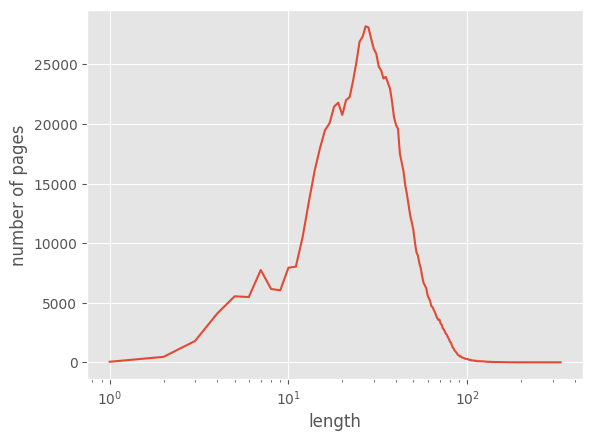

In [ ]:
text_by_length = text_data[0].str.len().value_counts().sort_index()

plt.plot(text_by_length.index, text_by_length.values)
plt.xlabel("length")
plt.ylabel("number of pages")
plt.xscale("log")

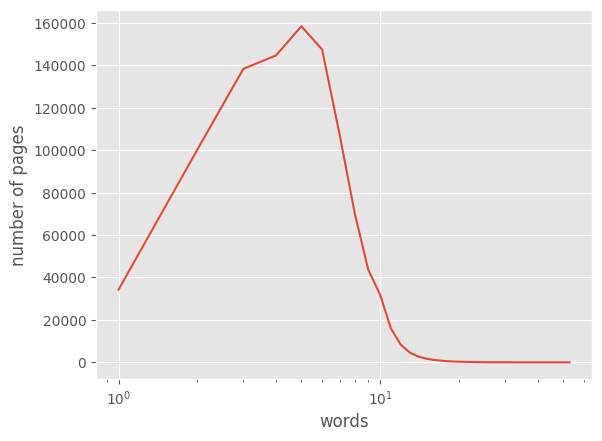

In [ ]:
text_by_words = text_data[0].str.split().apply(len).value_counts().sort_index()

plt.plot(text_by_words.index, text_by_words.values)
plt.xlabel("words")
plt.ylabel("number of pages")
plt.xscale("log")

In [ ]:
tokenized_texts = text_data[0].apply(str.split)
tokenized_texts

0                                                    [алиби]
1                                                   [сказка]
2                  [найди, в, нете, мульт, стальной, гигант]
3                                               [мона, лиза]
4                   [смотреть, сериал, восемь, с, половиной]
                                 ...                        
1014216    [афина, какие, военные, положения, в, россии, ...
1014217          [джой, могут, ли, соседи, вызвать, полицию]
1014218                     [сбер, с, каким, животным, себя]
1014219    [афина, какие, реквизиты, необходимы, для, про...
1014220    [афина, чем, является, обшивка, фермерских, фю...
Name: 0, Length: 1014221, dtype: object

In [ ]:
train_set, val_set = train_test_split(
    tokenized_texts, test_size=0.05, random_state=SEED
)

# N-gram Language Model

$$
    P(w_1, \dots, w_k) = \prod_t P(w_t \mid w_{t - n + 1}, \dots, w_{t - 1}).
$$

$$
    P(w_t \mid w_{t - n + 1}, \dots, w_{t - 1}) \approx \frac{\text{count} (w_{t - n + 1} \dots, w_{t - 1}, w_t)}{\displaystyle \sum_w \text{count} (w_{t - n + 1} \dots w_{t - 1}, w)}=\frac{\text{count} (w_{t - n + 1} \dots, w_{t - 1}, w_t)}{\text{count} (w_{t - n + 1} \dots w_{t - 1})}
$$

In [ ]:
BOS = "<BOS>"
EOS = "<EOS>"

ngrams_config = {
    "pad_left": True,
    "pad_right": True,
    "left_pad_symbol": BOS,
    "right_pad_symbol": EOS,
}


def build_ngram_counts(
    tokenized_texts: Iterable[Iterable[str]], n: int
) -> Dict[Tuple[str, ...], Dict[str, int]]:
    """
    встречаемость слова при условии (n - 1) предыдущего слова

    для n = 2:
        {
            ('добрый',): {'день': 273, 'вечер': 55, 'путь': 8, ...},
            ('машинное',): {'масло': 2, 'отделение': 6, 'обучение': 4, ...}
            ...
        }

    для n = 3:
         {
            ('<BOS>', '<BOS>'): {'мэр': 22, 'выпуск': 40, ...},
            ('<BOS>', 'мэр'): {'москвы': 3, 'перми': 3, ...},
            ...
        }
    """

    counts = defaultdict(Counter)

    for text in tokenized_texts:
        for ngram in nltk.ngrams(text, n, **ngrams_config):
            prefix = ngram[:-1]
            token = ngram[-1]
            counts[prefix][token] += 1

    return counts

In [ ]:
class LanguageModel:
    def __init__(self, tokenized_texts: Iterable[Iterable[str]], n: int) -> None:
        self.n: int = n
        self.probs: Dict[Tuple[str, ...], Dict[str, float]] = defaultdict(Counter)
        ngrams = build_ngram_counts(tokenized_texts, n)
        for prefix, distribution in ngrams.items():
            total_count = sum(distribution.values())
            self.probs[prefix] = Counter({
                token: count / total_count for token, count in distribution.items()
            })

    def get_token_distribution(self, prefix: List[str]) -> Dict[str, float]:
        prefix = prefix[max(0, len(prefix) - self.n + 1) :]
        prefix = [BOS] * (self.n - 1 - len(prefix)) + prefix
        return self.probs[tuple(prefix)]

    def get_next_token_prob(self, prefix: List[str], token: str) -> float:
        return self.get_token_distribution(prefix)[token]

    def perplexity(self,
                   tokenized_texts: Iterable[Iterable[str]],
                   min_logprob: float = np.log(10**-50.0),
                  ) -> float:
        logprobs_sum: float = 0.0
        N: int = 0
        for tokens in tokenized_texts:
            prefix = [BOS] * (self.n - 1)
            padded_tokens = tokens + [EOS]
            for token in padded_tokens:
                logprob = np.log(self.get_next_token_prob(prefix, token))
                prefix = prefix[1:] + [token]
                logprobs_sum += max(logprob, min_logprob)
            N += len(padded_tokens)
        return np.exp(-logprobs_sum / N)

In [ ]:
model = LanguageModel(train_set, n=2)

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 1087 (\N{CYRILLIC SMALL LETTER PE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 1086 (\N{CYRILLIC SMALL LETTER O}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 1089 (\N{CYRILLIC SMALL LETTER ES}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 1084 (\N{CYRILLIC SMALL LETTER EM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 1090 (\N{CYRILLIC SMALL LETTER TE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python

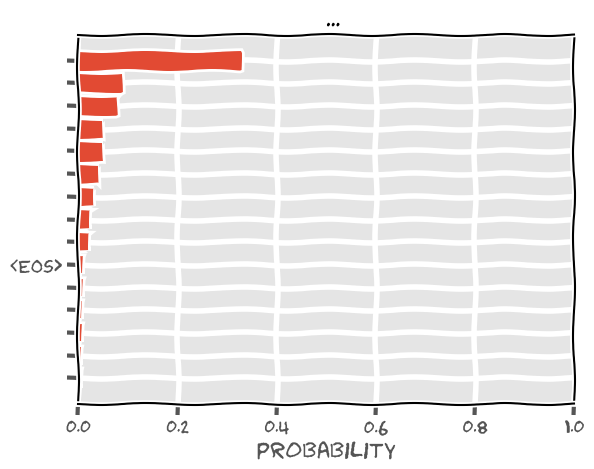

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 1080 (\N{CYRILLIC SMALL LETTER I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 1085 (\N{CYRILLIC SMALL LETTER EN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 1090 (\N{CYRILLIC SMALL LETTER TE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 1077 (\N{CYRILLIC SMALL LETTER IE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 1083 (\N{CYRILLIC SMALL LETTER EL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python

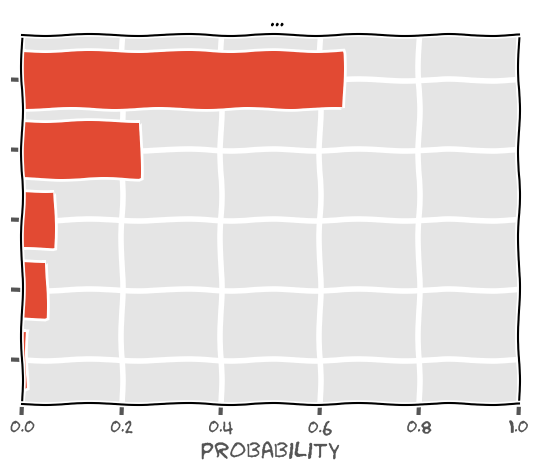

In [ ]:
def plot_distribution(
    distribution: Dict[str, float],
    top_k: int = None,
    title: str = None,
    xlim: bool = True,
) -> None:
    data = sorted(distribution.items(), key=lambda x: -x[1])
    if top_k:
        data = data[:top_k]

    with plt.xkcd():
        plt.barh([word for word, count in data], [count for word, count in data])
        if xlim:
            plt.xlim([0, 1])
        if title:
            plt.title(title)
        plt.gca().invert_yaxis()
        plt.xlabel("probability")
        plt.grid()
        plt.show()


for word in ("хочу", "искусственный"):
    plot_distribution(model.probs[(word,)], top_k=15, title=word + " ...")

In [ ]:
model.perplexity(val_set)

<ipython-input-18-857e80ccd54f>:30: RuntimeWarning: divide by zero encountered in log
  logprob = np.log(self.get_next_token_prob(prefix, token))


289388.3456147256

In [ ]:
len({token for tokens in train_set for token in tokens})

130077

### Laplace Smoothing

In [ ]:
class LaplaceLanguageModel(LanguageModel):
    def __init__(
        self, tokenized_texts: Iterable[Iterable[str]], n: int, delta: float = 1.0
    ):
        self.n = n
        ngram_counts = build_ngram_counts(tokenized_texts, n)

        self.vocab = {
            token for distribution in ngram_counts.values() for token in distribution
        }

        self.probs = defaultdict(Counter)

        for prefix, distribution in ngram_counts.items():
            norm: float = sum(distribution.values()) + delta * len(self.vocab)
            self.probs[prefix] = {
                token: (count + delta) / norm for token, count in distribution.items()
            }

    def get_token_distribution(self, prefix: List[str]) -> Dict[str, float]:
        distribution: Dict[str, float] = super().get_token_distribution(prefix)
        missing_prob_total: float = 1.0 - sum(distribution.values())
        missing_prob = missing_prob_total / max(1, len(self.vocab) - len(distribution))
        return {token: distribution.get(token, missing_prob) for token in self.vocab}

    def get_next_token_prob(self, prefix: List[str], next_token: str):
        distribution: Dict[str, float] = super().get_token_distribution(prefix)
        if next_token in distribution:
            return distribution[next_token]
        else:
            missing_prob_total = 1.0 - sum(distribution.values())
            return max(0, missing_prob_total) / max(
                1, len(self.vocab) - len(distribution)
            )

In [ ]:
for n in (2, 3):
    laplace_model = LaplaceLanguageModel(train_set, n=n)
    print(f"{n}: {laplace_model.perplexity(val_set)}")

2: 1317.4820149073462
3: 4432.507910137031


In [ ]:
delta_model = LaplaceLanguageModel(train_set, n=2, delta=1e-4)

In [ ]:
delta_model.perplexity(val_set)

96.39488387850265

# Metrics

In [ ]:
def dummy_edit_distance(ref: Iterable, hyp: Iterable) -> int:
    """
    dummy levenshtein implementation O(3^n)
    """
    if not ref:
        return len(hyp)
    if not hyp:
        return len(ref)
    return min(
        edit_distance(ref[1:], hyp[1:]) + (ref[0] != hyp[0]),  # Correct / Insertion
        edit_distance(ref, hyp[1:]) + 1,  # Deletion
        edit_distance(ref[1:], hyp) + 1,  # Substitution
    )


def edit_distance(ref: Iterable, hyp: Iterable, plot: bool = False) -> int:
    """
    dynamic programming levenshtein implementation O(n^2)
    """

    dist = np.zeros((len(hyp) + 1, len(ref) + 1), dtype=np.int32)

    dist[:, 0] = np.arange(len(hyp) + 1)
    dist[0, :] = np.arange(len(ref) + 1)

    for i, r in enumerate(hyp, start=1):
        for j, h in enumerate(ref, start=1):
            dist[i, j] = min(
                dist[i - 1, j - 1] + (r != h), dist[i, j - 1] + 1, dist[i - 1, j] + 1
            )
    if plot:
        sns.heatmap(
            pd.DataFrame(dist, index=[" "] + list(hyp), columns=[" "] + list(ref)),
            annot=True,
            cmap="coolwarm_r",
            linewidth=2,
        )
        plt.tick_params(
            axis="both",
            which="major",
            labelsize=14,
            left=False,
            labelbottom=False,
            bottom=False,
            top=False,
            labeltop=True,
        )
        plt.yticks(rotation=0)
        plt.show()

    return dist[-1, -1]

In [ ]:
def error_rate(*, refs: Iterable[Iterable], hyps: Iterable[Iterable]) -> float:
    """
    ignoring hypotheses with empty references
    """

    wrong_words, all_words = 0, 0

    for ref, hyp in tqdm(zip(refs, hyps), total=len(refs)):
        if len(ref) > 0:
            wrong_words += edit_distance(ref, hyp)
            all_words += len(ref)
        else:
            continue
    return wrong_words / all_words if all_words > 0 else 0.0


def wer(*, refs: Iterable[str], hyps: Iterable[str]) -> float:
    """
    Word Error Rate
    """
    return error_rate(
        refs=[ref.split() for ref in refs], hyps=[hyp.split() for hyp in hyps]
    )


def cer(*, refs: Iterable[str], hyps: Iterable[str]) -> float:
    """
    Character Error Rate
    """
    return error_rate(refs=refs, hyps=hyps)

In [ ]:
class PrettyDict(dict):
    def __repr__(self):
        return tabulate(
            sorted(
                [[k, round(v * 100, 2)] for k, v in self.items()],
                key=lambda x: x[1],
                reverse=True,
            ),
            tablefmt="orgtbl",
            headers=("method", "WER, %"),
        )

def get_wer(data):
    return PrettyDict(
                    {model: wer(hyps=data[model], refs=data["text"]) for model in MODEL_LIST}
                    )

# Oracle WER и CER

если представить, что мы идеально выбираем лучшую из трех гипотез (Оракул), какими будут WER и CER?\
таким образом оценим нижнюю границу Rescoring-системы

In [ ]:
MODEL_LIST = ['qnet', 'w2v', 'w2v_tts']

In [ ]:
def get_best_transcription(ref: Iterable[str], hyps: Iterable[Iterable[str]]):
    return hyps[np.array([edit_distance(ref, hyp) for hyp in hyps]).argmin()]

In [ ]:
oracle_hyp = val_df.apply(
    lambda row: " ".join(
        get_best_transcription(
            ref=row["text"].split(), hyps=[row[model].split() for model in MODEL_LIST]
        )
    ),
    axis=1,
)

In [ ]:
method2wer = get_wer(val_df)
method2wer["oracle_wer"] = wer(refs=val_df["text"], hyps=oracle_hyp)
method2wer

  0%|          | 0/12354 [00:00<?, ?it/s]

  0%|          | 0/12354 [00:00<?, ?it/s]

  0%|          | 0/12354 [00:00<?, ?it/s]

  0%|          | 0/12354 [00:00<?, ?it/s]

| method     |   WER, % |
|------------+----------|
| qnet       |    94.87 |
| w2v_tts    |    71.06 |
| w2v        |    65.46 |
| oracle_wer |    49.48 |

## Улучшим rescoring по WER, применяя языковую модель

In [ ]:
delta_char_model = LaplaceLanguageModel(n=6, tokenized_texts=train_df['text'], delta=1e-2)

In [ ]:
delta_char_model.perplexity(val_df['text'].apply(list))

3.490606733642127

In [ ]:
# лучшее предложение с точки зрения delta_model по словам
def best(sentences: Iterable[str]):
    return ' '.join(min([[sent.split()] for sent in sentences], key=delta_model.perplexity)[0])

In [ ]:
# лучшее предложение с точки зрения delta_char model по символам
def best_char(sentences):
    res = min([[list(sent)] for sent in sentences], key=delta_char_model.perplexity)[0]
    return ''.join(res)

In [ ]:
MODEL_LIST = ['qnet', 'w2v_tts', 'w2v']

In [ ]:
max_likelihood_utterances = val_df.apply(
    lambda row: best_char(row[model] for model in MODEL_LIST),
    axis=1,
)

In [ ]:
method2wer = get_wer(val_df)
method2wer["rescoring"] = wer(hyps=val_df["text"], refs=max_likelihood_utterances)
method2wer

  0%|          | 0/12354 [00:00<?, ?it/s]

  0%|          | 0/12354 [00:00<?, ?it/s]

  0%|          | 0/12354 [00:00<?, ?it/s]

  0%|          | 0/12354 [00:00<?, ?it/s]

| method    |   WER, % |
|-----------+----------|
| qnet      |    94.87 |
| w2v_tts   |    71.06 |
| w2v       |    65.46 |
| rescoring |    49.3  |

Таким образом, мы добились максимума в rescoring

## Попробуем увеличить качество, исправляя ошибки

С помощью выравнивания посмотрим, где модели чаще всего ошибаются

In [ ]:
def align(ref: Iterable, hyp: Iterable) -> List[Tuple[str, str, str]]:
    dist = np.zeros((len(hyp) + 1, len(ref) + 1), dtype=np.int32)

    dist[:, 0] = np.arange(len(hyp) + 1)
    dist[0, :] = np.arange(len(ref) + 1)

    cache = [[None] * (len(ref) + 1) for _ in range(len(hyp) + 1)]

    for i, h in enumerate(hyp, start=1):
        cache[i][0] = ("I", "%", h)

    for i, r in enumerate(ref, start=1):
        cache[0][i] = ("D", r, "#")

    for i, h in enumerate(hyp, start=1):
        for j, r in enumerate(ref, start=1):
            cases = []

            if r == h:
                cases.append((dist[i - 1, j - 1], ("C", r, h)))
            else:
                cases.append((dist[i - 1, j - 1] + 1, ("S", r, h)))
            cases.append((dist[i, j - 1] + 1, ("D", r, "#")))
            cases.append((dist[i - 1, j] + 1, ("I", "%", h)))

            dist[i, j], cache[i][j] = min(cases, key=lambda x: x[0])

    alignment = []
    i, j = len(hyp), len(ref)

    while i != 0 or j != 0:
        action, r, h = cache[i][j]
        alignment.append((action, r, h))
        if action in {"C", "S"}:
            i -= 1
            j -= 1
        elif action == "I":
            i -= 1
        else:
            j -= 1

    return alignment[::-1]

In [ ]:
all_errors_s = Counter([tup[1:] for _, row in train_df.iterrows() for tup in align(row[1], row[4]) if tup[0] == 'S'])
all_errors_s = sorted(all_errors_s.items(), key=lambda error: -error[1])
all_errors_s

[(('а', 'о'), 5872),
 (('о', 'а'), 4875),
 (('и', 'е'), 4249),
 (('е', 'и'), 3240),
 (('о', ' '), 1937),
 (('о', 'у'), 1514),
 (('д', 'т'), 941),
 (('е', 'я'), 872),
 (('я', 'е'), 733),
 (('е', ' '), 718),
 (('у', 'о'), 675),
 (('с', 'ц'), 640),
 (('э', 'е'), 575),
 (('т', 'д'), 546),
 (('й', 'е'), 428),
 (('г', 'к'), 424),
 (('ф', 'в'), 418),
 (('о', 'е'), 414),
 (('з', 'с'), 412),
 (('е', 'а'), 397),
 (('о', 'ы'), 365),
 (('с', 'з'), 360),
 ((' ', 'о'), 359),
 (('б', 'п'), 350),
 (('й', 'и'), 349),
 (('а', ' '), 323),
 (('н', 'м'), 318),
 (('у', 'л'), 299),
 (('ц', 'с'), 283),
 (('и', ' '), 282),
 (('ь', 'и'), 280),
 (('и', 'л'), 274),
 (('к', 'г'), 268),
 (('ы', 'а'), 254),
 (('а', 'ы'), 253),
 (('ы', 'о'), 227),
 (('е', 'ы'), 227),
 (('с', ' '), 226),
 (('е', 'о'), 220),
 (('а', 'е'), 218),
 (('ж', 'ш'), 214),
 ((' ', 'а'), 212),
 (('и', 'ь'), 206),
 (('я', 'и'), 205),
 (('в', 'г'), 197),
 (('м', 'н'), 197),
 (('и', 'я'), 193),
 (('я', 'й'), 192),
 (('д', ' '), 191),
 (('о', 'л'), 

In [ ]:
all_errors_d = Counter([tup[1:] for _, row in train_df.iterrows() for tup in align(row[1], row[4]) if tup[0] == 'D'])
all_errors_d = sorted(all_errors_d.items(), key=lambda error: -error[1])
all_errors_d

[(('о', '#'), 2944),
 ((' ', '#'), 2175),
 (('й', '#'), 779),
 (('ь', '#'), 773),
 (('д', '#'), 739),
 (('р', '#'), 687),
 (('а', '#'), 642),
 (('т', '#'), 632),
 (('с', '#'), 610),
 (('л', '#'), 609),
 (('е', '#'), 514),
 (('и', '#'), 509),
 (('н', '#'), 361),
 (('в', '#'), 289),
 (('у', '#'), 280),
 (('м', '#'), 258),
 (('я', '#'), 218),
 (('к', '#'), 216),
 (('э', '#'), 166),
 (('ы', '#'), 134),
 (('г', '#'), 118),
 (('ц', '#'), 107),
 (('п', '#'), 100),
 (('ф', '#'), 99),
 (('з', '#'), 77),
 (('б', '#'), 76),
 (('ж', '#'), 68),
 (('х', '#'), 60),
 (('ч', '#'), 59),
 (('ш', '#'), 47),
 (('ъ', '#'), 42),
 (('ю', '#'), 13)]

In [ ]:
all_errors_i = Counter([tup[1:] for _, row in train_df.iterrows() for tup in align(row[1], row[4]) if tup[0] == 'I'])
all_errors_i = sorted(all_errors_i.items(), key=lambda error: -error[1])
all_errors_i

[(('%', ' '), 14030),
 (('%', 'а'), 3192),
 (('%', 'е'), 2480),
 (('%', 'о'), 2148),
 (('%', 'и'), 1781),
 (('%', 'в'), 1115),
 (('%', 'ы'), 1095),
 (('%', 'т'), 1054),
 (('%', 'ь'), 1053),
 (('%', 'л'), 919),
 (('%', 'й'), 858),
 (('%', 'э'), 808),
 (('%', 'у'), 760),
 (('%', 'н'), 689),
 (('%', 'к'), 576),
 (('%', 'м'), 556),
 (('%', 'я'), 503),
 (('%', 'д'), 489),
 (('%', 'с'), 470),
 (('%', 'р'), 456),
 (('%', 'п'), 320),
 (('%', 'г'), 218),
 (('%', 'з'), 152),
 (('%', 'х'), 122),
 (('%', 'ш'), 117),
 (('%', 'ю'), 100),
 (('%', 'ч'), 83),
 (('%', 'б'), 83),
 (('%', 'ц'), 66),
 (('%', 'ж'), 49),
 (('%', 'ф'), 48),
 (('%', '-'), 14),
 (('%', 'щ'), 13),
 (('%', 'ъ'), 6)]

In [ ]:
errors_s = [error[0] for error in all_errors_s[0:25]]
errors_d = [error[0][0]for error in all_errors_d[0:2]]
errors_i = [error[0][1] for error in all_errors_i[0:0]] # не будем использовать вставки

In [ ]:
def del_smth(sentence: str) -> Set[str]:
    dels = []
    words = re.split('[' + ''.join(errors_d[1:]) + ']', sentence)
    for i in range(1, len(words)):
        if len(words[i - 1]) + len(words[i]) <= 10:
            dels.append(' '.join(words[:i - 1] + [words[i - 1] + words[i]] + words[i + 1:]))
    return set(dels)

def x2_del_smth(sentence: str) -> str:
    dels = del_smth(sentence)
    dels.update({x2_edited for edited in dels for x2_edited in del_smth(edited)})
    return dels

def sub_smth(sentence: str) -> Set[str]:
    splits = [(sentence[:i], sentence[i:]) for i in range(len(sentence) + 1)]
    subs = [left + sub[1] + right[1:] for left, right in splits for sub in errors_s if sub[0] == right[0:1]]
    subs = [s.replace('  ', ' ').strip() for s in subs]
    return set(subs)

def insert_smth(sentence: str) -> Set[str]:
    splits = [(sentence[:i], sentence[i:]) for i in range(len(sentence) + 1)]
    insertions = {left + c + right for left, right in splits for c in errors_i}
    return insertions

def correct(sentence: str) -> str:
    sub_deleted = {sub for edited in x2_del_smth(sentence) for sub in sub_smth(edited)}
    candidates = {sentence} | sub_smth(sentence) | x2_del_smth(sentence) | sub_deleted
    return best_char(candidates)

In [ ]:
%%time

val_df['w2v_corrected'] = val_df.apply(lambda row: correct(row['w2v']), axis=1)
val_df['w2v_tts_corrected'] = val_df.apply(lambda row: correct(row['w2v_tts']), axis=1)
val_df['qnet_corrected'] = val_df.apply(lambda row: correct(row['qnet']), axis=1)

CPU times: user 4min 44s, sys: 875 ms, total: 4min 45s
Wall time: 4min 47s


In [ ]:
MODEL_LIST = ['qnet', 'w2v', 'w2v_tts', 'qnet_corrected', 'w2v_corrected', 'w2v_tts_corrected']

In [ ]:
max_likelihood_utterances = val_df.apply(
    lambda row: best_char(row[model] for model in MODEL_LIST),
    axis=1,
)
method2wer = get_wer(val_df)
method2wer["rescoring"] = wer(hyps=val_df["text"], refs=max_likelihood_utterances)
method2wer

  0%|          | 0/12354 [00:00<?, ?it/s]

  0%|          | 0/12354 [00:00<?, ?it/s]

  0%|          | 0/12354 [00:00<?, ?it/s]

  0%|          | 0/12354 [00:00<?, ?it/s]

  0%|          | 0/12354 [00:00<?, ?it/s]

  0%|          | 0/12354 [00:00<?, ?it/s]

  0%|          | 0/12354 [00:00<?, ?it/s]

| method            |   WER, % |
|-------------------+----------|
| qnet              |    94.87 |
| qnet_corrected    |    71.16 |
| w2v_tts           |    71.06 |
| w2v               |    65.46 |
| w2v_tts_corrected |    51.56 |
| w2v_corrected     |    45    |
| rescoring         |    37.68 |

## Сгенерируем новый вариант с помощью ROVER

In [ ]:
def get_rover_df(
    df: pd.DataFrame, model_cols: List[str], tmp_col: str = "__tmp"
) -> pd.DataFrame:
    rover_df = df.copy()

    if "text" in rover_df.columns:
        rover_df.drop("text", axis=1, inplace=True)

    rover_df[tmp_col] = rover_df.apply(
        lambda row: [(model, row[model]) for model in model_cols], axis=1
    )

    rover_df = rover_df.drop(model_cols, axis=1).explode(tmp_col)

    return pd.DataFrame(
        {
            "task": rover_df["task"],
            "performer": rover_df[tmp_col].apply(lambda x: x[0]),
            "text": rover_df[tmp_col].apply(lambda x: x[1]),
        }
    )

Будем выбирать только из исправленных вариантов

In [ ]:
MODEL_LIST = ['qnet_corrected', 'w2v_corrected', 'w2v_tts_corrected']

In [ ]:
val_rover_df = get_rover_df(val_df, model_cols=MODEL_LIST)

In [ ]:
rover_result = ROVER(tokenizer=list, detokenizer="".join, silent=False).fit_predict(
    val_rover_df
)

  0%|          | 0/12354 [00:00<?, ?it/s]

In [ ]:
val_df = pd.merge(val_df, rover_result.reset_index(), on="task")

In [ ]:
val_df

,task,text,qnet,w2v,w2v_tts,w2v_corrected,w2v_tts_corrected,qnet_corrected,agg_text
0,3c2875271fb918da312865549d444653,антонине татариновой,онпанине то тариновый,антонине татариновый,антонини татариновый,антонине татаринавый,антонини татаринавый,онпанинето таринавый,антонине татаринавый
1,1254c97d2434297a886e4dc4b2a16863,илюши власова,илюши влассво,и люши власово,и люше власова,илюши власова,илюши власова,илюши влоссво,илюши власова
2,867e45b9a914fffff0c8ef976ee0a275,терехину,тере гину,терехину,терьехину,терехино,терьихину,терекину,терехину
3,32d052f80c431869e7c13914b88f958e,айдарчике,а и дарчики,аидарчике,а и дарчике,аидарчика,аидарчика,аидарчики,аидарчика
4,719cbc316c0f3caa6324c110ad899b81,ксении валерьевны волковой,сени и воверивны в волколы,к сени и валеревны волковой,ксение ивалиревной волковой,ксении валеривны волковой,ксения ивалиревной волковой,сени и выверивныв волколы,ксени и валеривный волковой
...,...,...,...,...,...,...,...,...,...
12349,b2c4360bffc98f20b59fc6e6c3f1a606,фармэконом,фар мы коном,фар мконом,фар мыконон,фармканом,фармыконын,фармыканом,фармыканом
12350,de0fd646bdd3b37697580c2cc2d7d624,ссср бронь,этозысер бронь,эсососэр бронь,эсисыцар бронь,эс сосэр бронь,есисыцар бронь,этазысер бронь,эсисысэр бронь
12351,97d2af838eb539e5a7151b099e13498d,фото салончик,хот то солоничиак,фот -то солончик,фото солоничек а,фот-то салончик,фото салоничека,хот то салоничиак,фот-то салоничик
12352,f8df9effaf84f5aaa1f33c3e2cf4ad5a,седьмой кассационный суд общей юрисдикции телефон,седьмой катоционный суд общей юрисдикции телефон,седьмой кассационный суд общей юрисдикции тел...,седьмой касационный суд общей юрисдикции телефон,седьмое кассационный судобщей юрисдикции телефон,седьмой косационный судобщей юрисдикции телефон,седьмой катационный судобщей юрисдикции телефон,седьмой касационный судобщей юрисдикции телефон


Попробуем скорректировать ещё и результат ROVER

In [ ]:
val_df['agg_text_corrected'] = val_df.apply(lambda row: correct(row['agg_text']), axis=1)

In [ ]:
MODEL_LIST = ['qnet', 'qnet_corrected', 'w2v', 'w2v_tts', 'w2v_corrected', 'w2v_tts_corrected', 'agg_text',
              'agg_text_corrected']

In [ ]:
max_likelihood_utterances = val_df.apply(
    lambda row: best_char(row[model] for model in MODEL_LIST),
    axis=1,
)
method2wer = get_wer(val_df)
method2wer["rescoring"] = wer(hyps=val_df["text"], refs=max_likelihood_utterances)
method2wer

  0%|          | 0/12354 [00:00<?, ?it/s]

  0%|          | 0/12354 [00:00<?, ?it/s]

  0%|          | 0/12354 [00:00<?, ?it/s]

  0%|          | 0/12354 [00:00<?, ?it/s]

  0%|          | 0/12354 [00:00<?, ?it/s]

  0%|          | 0/12354 [00:00<?, ?it/s]

  0%|          | 0/12354 [00:00<?, ?it/s]

  0%|          | 0/12354 [00:00<?, ?it/s]

  0%|          | 0/12354 [00:00<?, ?it/s]

| method             |   WER, % |
|--------------------+----------|
| qnet               |    94.87 |
| qnet_corrected     |    71.16 |
| w2v_tts            |    71.06 |
| w2v                |    65.46 |
| w2v_tts_corrected  |    51.56 |
| w2v_corrected      |    45    |
| agg_text           |    44.84 |
| agg_text_corrected |    43.25 |
| rescoring          |    36.53 |

# Prediction

In [ ]:
test_df.head()

,task,qnet,w2v,w2v_tts
0,73aff8bc8d99278c6ca6d1ac243557e3,дели,зили,зили
1,ba8443f3cc91e56667278db36dea02b7,вектор упавнович чунула к лещенуму,виктору павловичу новокрещеному,виктору павлновичу навокрещинову оо
2,af346fae1d5686a357e32710c5d4f13e,риме менниковой,римми мельниковой,рымми мельниковой
3,262fda7ab40a8417b99ecb314b3f7405,александровик провичо,александру викторовичу,александру викторовичу
4,08bd8fb35ceaf2843734ffeb389f2283,я ро славцов,ерославцев,ярославцев


In [ ]:
%%time

test_df['w2v_corrected'] = test_df.apply(lambda row: correct(row['w2v']), axis=1)
test_df['w2v_tts_corrected'] = test_df.apply(lambda row: correct(row['w2v_tts']), axis=1)
test_df['qnet_corrected'] = test_df.apply(lambda row: correct(row['qnet']), axis=1)

CPU times: user 7min 36s, sys: 1.65 s, total: 7min 37s
Wall time: 7min 42s


In [ ]:
MODEL_LIST = ['qnet_corrected', 'w2v_corrected', 'w2v_tts_corrected']
test_rover_df = get_rover_df(test_df, model_cols=MODEL_LIST)

In [ ]:
rover_result = ROVER(tokenizer=list, detokenizer="".join, silent=False).fit_predict(
    test_rover_df
)

  0%|          | 0/18875 [00:00<?, ?it/s]

In [ ]:
test_df = pd.merge(test_df, rover_result.reset_index(), on="task")

In [ ]:
test_df['agg_text_corrected'] = test_df.apply(lambda row: correct(row['agg_text']), axis=1)

In [ ]:
MODEL_LIST = ['qnet', 'qnet_corrected', 'w2v', 'w2v_tts', 'w2v_corrected', 'w2v_tts_corrected', 'agg_text',
              'agg_text_corrected']

In [ ]:
test_df['rescoring'] = test_df.apply(
    lambda row: best_char(row[model] for model in MODEL_LIST),
    axis=1,
)

In [ ]:
result = test_df[['task', 'rescoring']].rename({'rescoring': 'prediction'}, axis=1)
result

,task,prediction
0,73aff8bc8d99278c6ca6d1ac243557e3,тели
1,ba8443f3cc91e56667278db36dea02b7,викторо павловичу новокрещеному
2,af346fae1d5686a357e32710c5d4f13e,римме мельниковой
3,262fda7ab40a8417b99ecb314b3f7405,александру викторовичу
4,08bd8fb35ceaf2843734ffeb389f2283,ярославцев
...,...,...
18870,35e142d32571927fa08227a5d1a89152,пермский государственный институт культуры
18871,0c7beaae1712adf488fae74a4966b661,даль фарма на карте
18872,5de895309c234ced55d31f001e930250,городская поликлиника номер одиннадцать
18873,beda99f2bada550facb9a70c1c48a62b,билет шафран


In [ ]:
username = "Будин_Влад"

result.to_json(
    f"noisy_text_aggregation_test_prediction_{username}.jsonl",
    lines=True, orient="records"
)